# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** June 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter, geopandas

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github]()

---
**Assignment:**

Using a shapefile with country boundaries, show a table of which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino and La Nina events.

&emsp;Hints:
- Use World_Countries_Generalized.shp for country boundaries and subset to South America
- Repeat the appropriate steps from science questions 1 and 3
- Use the country boundaries on your gridded results to quantify which countries experience anomalous T and PR at the 50% area threshold
- Format your results in a pandas dataframe. Sort the dataframe descending by percent area impacted by anomalous conditions.

# Import packages and define workspace

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import geopandas as gpd
import warnings
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

import shapely
import xagg
# from cdo import *
# cdo   = Cdo()  

In [2]:
# create a folder for data downloads
if not os.path.exists('../data/World_Countries'):
    os.makedirs('../data/World_Countries')

In [3]:
# filenames to save data to and download urls
base_filename='../data/World_Countries/World_Countries'

shpfile_info=  {'.cpg':'https://osf.io/5xrgc/download',
                '.dbf':'https://osf.io/3a6rp/download',
                '.prj':'https://osf.io/43mnp/download',
                '.shp':'https://osf.io/r4dez/download',
                '.shp.xml':'https://osf.io/s4cvy/download',
                '.shx':'https://osf.io/kp6cm/download'}

# files we've already downloaded
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'
pr_f = '../data/precip_monthly_PRECL_NOAA.nc'

# Obtaining the data

We'll use a shapefile of country boundaries called [World Countries, originally obtained from ESRI ArcGIS Hub](https://hub.arcgis.com/datasets/esri::world-countries/explore) in June 2024 and copied to the [enso component of the MSU_py_training OSF project](https://osf.io/e726y/). 

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data files will then be located on your computer. Files total approximately 130MB in size.**
</b></font> 

In [4]:
# download shapefile

for ext,url in shpfile_info.items():
    filename=base_filename+ext
    print('downloading',filename)
    urlretrieve(url,filename) # download and save data

downloading ../data/World_Countries/World_Countries.cpg
downloading ../data/World_Countries/World_Countries.dbf
downloading ../data/World_Countries/World_Countries.prj
downloading ../data/World_Countries/World_Countries.shp
downloading ../data/World_Countries/World_Countries.shp.xml
downloading ../data/World_Countries/World_Countries.shx


# Data Cleaning

We'll copy over the data cleaning steps from the enso_analysis.ipynb as well as subset global country boundaries to South American countries 

In [5]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

In [6]:
# data cleaning copied from enso_analysis.ipynb

# Nino 3.4 data
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten() 
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates}) 
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

# precipitation data
ds=xr.open_dataset(pr_f)
pr=ds.precip
pr=pr.sel(time=slice(year_start,year_end)) 
pr=pr.reindex(lat=pr.lat[::-1]) 
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)
pr_base=pr.sel(time=slice(base_start,base_end)) 
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time') 
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim  
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  # subset in time
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  # long term means for each month
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# check first and last time is the same for all data
variables=[nino, pr_anom, t_anom] # list of arrays
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

# clean up
del ds, nino_raw, pr, pr_base, pr_clim,  t, t_anom_5180, t_base

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


In [7]:
# load shapefile of global country boundaries
countries=gpd.read_file(base_filename+'.shp')
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Afghanistan,AFG,Asia,Primary land,5,Afghanistan,"POLYGON ((7903664.312 4647353.724, 7904616.405..."
1,Albania,ALB,Europe,Primary land,5,Albania,"POLYGON ((2198549.632 5255559.625, 2198549.632..."
2,Albania,ALB,Europe,Very small island,1,Albania,"MULTIPOLYGON (((2225504.394 4833346.591, 22255..."
3,Albania,ALB,Europe,Small island,2,Albania,"MULTIPOLYGON (((2146282.762 4939350.329, 21465..."
4,Algeria,DZA,Africa,Small island,2,Algeria,"POLYGON ((-125686.175 4262793.127, -125721.541..."
...,...,...,...,...,...,...,...
646,Yemen,YEM,Asia,Very small island,1,Yemen,"MULTIPOLYGON (((5803828.604 1395645.899, 58035..."
647,Yemen,YEM,Asia,Small island,2,Yemen,"MULTIPOLYGON (((5931926.381 1360057.795, 59327..."
648,Yemen,YEM,Asia,Medium island,3,Yemen,"POLYGON ((5960626.667 1426907.772, 5961018.46 ..."
649,Zambia,ZMB,Africa,Primary land,5,Zambia,"POLYGON ((3461259.84 -964526.128, 3462999.22 -..."


In [8]:
countries.crs
# options:
# 1) project both countries and data to equal area projections
# 2) unproject countries and use the built in geopandas function to compute are on non-projected country polygons


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# trying unproject first

# subset to south america
countries=countries.loc[(countries['CONTINENT']=='South America')
                        &(countries['LAND_TYPE'].str.contains('Primary land'))].reset_index(drop=True)
countries=countries.to_crs("epsg:4326")
countries

# array(['Argentina', 'Aruba', 'Bolivia', 'Bonaire', 'Brazil', 'Chile',
#        'Colombia', 'Curacao', 'Ecuador', 'Falkland Islands',
#        'French Guiana', 'Guyana', 'Paraguay', 'Peru', 'Suriname',
#        'Trinidad and Tobago', 'Uruguay', 'Venezuela'], dtype=object)

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424..."
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716..."
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333..."
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619..."
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2..."
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.2443 -3.33325, -80.2438 -3..."
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.8391,..."
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8..."
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2..."
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166..."


In [10]:
# # countries.crs.is_geographic
# # not countries.crs
# geod = countries.crs.get_geod()
# geod

In [11]:
# countries.geometry[0].geoms[0].exterior

In [12]:
# # shapely.geometry.polygon.orient(countries.geometry[0].geoms[0], 1)
# # countries.geometry.geom_type#.crs#[9].geom_type
# # all(countries.geometry.geom_type).str.contains(['MultiPolygon','Polygon'])
# countries.geometry.geom_type.isin(['MultiPolygon','Polygon'])
# all(countries.geometry.geom_type.isin(['MultiPolygon','Polygon']))

In [13]:
# geod.geometry_area_perimeter(orient(geom, 1))[0]
# test= countries.geometry[0].geoms[0]
# test.exterior

# geod = countries.crs.get_geod()
# area_km2=[geod.geometry_area_perimeter(shapely.geometry.polygon.orient(geom,1))[0]/(1000^2) for geom in countries.geometry[0].geoms]
# area_km2


In [14]:
from shapely.geometry.polygon import orient
def gpd_geographic_area(geodf):
    if not geodf.crs and geodf.crs.is_geographic:
        raise TypeError('geodataframe should have geographic coordinate system')
        
    geod = geodf.crs.get_geod()
    def area_calc(geom):
        if geom.geom_type not in ['MultiPolygon','Polygon']:
            return np.nan
        
        # For MultiPolygon do each separately
        if geom.geom_type=='MultiPolygon':
            return np.sum([area_calc(p) for p in geom.geoms])/(1000^2)

        # orient to ensure a counter-clockwise traversal. 
        # See https://pyproj4.github.io/pyproj/stable/api/geod.html
        # geometry_area_perimeter returns (area, perimeter)
        return geod.geometry_area_perimeter(orient(geom, 1))[0]/(1000^2)
    
    return geodf.geometry.apply(area_calc)

In [15]:
countries['area_km2']=gpd_geographic_area(countries)
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry,area_km2
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424...",2.764644e+06
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716...",1.080448e+09
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333...",8.409169e+06
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619...",6.863458e+05
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2...",1.130327e+06
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.2443 -3.33325, -80.2438 -3...",2.451759e+05
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.8391,...",8.302624e+07
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8...",2.095301e+05
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2...",3.999487e+08
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166...",1.289477e+09


In [16]:
# # this function operates on a single polygon or multipolygon
# # and can be applied to a geodataframe
# def area_calc(geom):
#     if not all(geom.geom_type.isin(['MultiPolygon','Polygon'])):
#         raise TypeError('some geometries are not polygon or multipolygon')

#     geod = geom.crs.get_geod()        
#     if geom.geom_type=='MultiPolygon':
#         # For multipolygon do each polygon separately and sum
#         return np.sum([geod.geometry_area_perimeter(shapely.geometry.polygon.orient(p,1))[0]/(1000^2) for p in geom.geoms])
#     else:
#         return geod.geometry_area_perimeter(shapely.geometry.polygon.orient(geom,1))[0]/(1000^2)

In [17]:
# # geod = countries.crs.get_geod()
# countries.geometry.apply(area_calc)
# # countries.apply(area_calc)

In [18]:
# # get country areas
# geod = countries.crs.get_geod()




# from shapely.geometry.polygon import orient
# def gpd_geographic_area(geodf):
#     if not geodf.crs and geodf.crs.is_geographic:
#         raise TypeError('geodataframe should have geographic coordinate system')
        
#     geod = geodf.crs.get_geod()
#     def area_calc(geom):
#         if geom.geom_type not in ['MultiPolygon','Polygon']:
#             return np.nan
        
#         # For MultiPolygon do each separately
#         if geom.geom_type=='MultiPolygon':
#             return np.sum([area_calc(p) for p in geom.geoms])

#         # orient to ensure a counter-clockwise traversal. 
#         # See https://pyproj4.github.io/pyproj/stable/api/geod.html
#         # geometry_area_perimeter returns (area, perimeter)
#         return geod.geometry_area_perimeter(orient(geom, 1))[0]
    
#     return geodf.geometry.apply(area_calc)

In [19]:
# # count how many different countries and see their names
# print(len(countries.COUNTRY.unique()))
# countries.COUNTRY.unique()

# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the code that creates the array `nino_events` 

In [20]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our El Nino composite and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb

t nino and non-nino sample sizes: 44 184


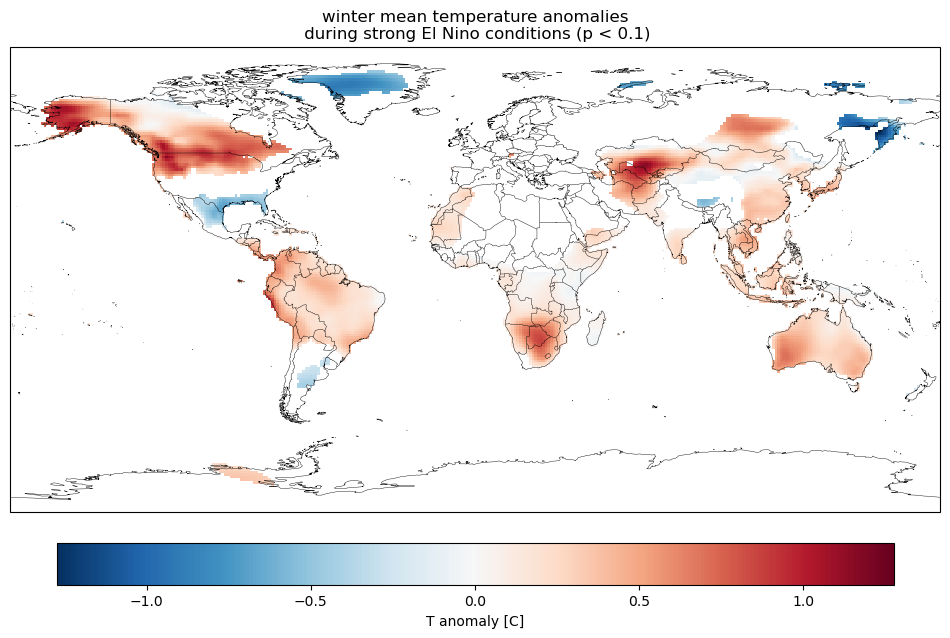

In [21]:
# copied from question 3 in enso_analysis.ipynb

# starting with el nino conditions, temperature
# get temperature anomalies only for times during strong el nino conditions
t_nino=t_anom.where(nino_events==1,drop=True)

# now separate out winter DJF months
# this is sample 1: winter months during strong el nino conditions
t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF'] 

# make a composite
t_nino_DJF_composite=t_nino_DJF.mean('time',keep_attrs=True)

# create a t sample that include all winter months DJF when there are not strong el nino conditions

# all months that don't fall in strong nino events
t_other=t_anom.where(nino_events!=1,drop=True) 

# pull out just DJF months
# this is sample 2: all winter months that are NOT during strong el nino conditions
t_other_DJF=t_other.groupby(t_other.time.dt.season)['DJF'] 

print('t nino and non-nino sample sizes:',t_nino_DJF.shape[0],t_other_DJF.shape[0]) 

# t-test for difference in means 
t_sigtest = ss.ttest_ind(t_nino_DJF, t_other_DJF, axis=0, equal_var=False)
# numpy --> xarray
t_nino_pval = xr.DataArray(t_sigtest.pvalue, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})


# plot el nino temperature anomalies where statistically significant at 90% level
pval=0.1

fig=plt.figure(figsize=(12,8))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_pval<pval).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'winter mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

plt.show()


Now we can use our shapefile to answer the question: which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino? 

In [31]:
t_nino_DJF_composite

<xarray.DataArray 'tavg' (lat: 180, lon: 360)> Size: 259kB
array([[-0.05417551, -0.05384723, -0.05352813, ..., -0.05519971,
        -0.05485266, -0.05451055],
       [-0.01103011, -0.01011099, -0.00920994, ..., -0.01389625,
        -0.01292047, -0.01196289],
       [ 0.02968025,  0.03112871,  0.03255376, ...,  0.02517492,
         0.0267008 ,  0.02820158],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  T anomaly
    units:          C

In [ ]:
# first create a pandas dataframe from our results t_nino_DJF_composite and t_nino_pval

# convert each xarray data array object to a pandas data frame
t_nino_DJF_composite_df=t_nino_DJF_composite.to_dataframe().reset_index(level=[0,1])

t_nino_pval.name='pval'
t_nino_pval_df=t_nino_pval.to_dataframe().reset_index(level=[0,1])

# # merge pvalues into t_nino_DJF_composite_df
t_nino_DJF_composite_df=t_nino_DJF_composite_df.merge(t_nino_pval_df, how='left',on=['lat','lon'])
t_nino_DJF_composite_df

In [ ]:
t_nino_DJF_composite_df.crs

In [36]:
# now use the xagg package to compute the overlaps between grid cell polygons and country polygons
# pixel_overlaps computes the relative area of overlap for each grid cell polygon
# it takes an xarray dataset and a geopandas dataframe as inputs
# see https://xagg.readthedocs.io/en/latest/xagg.html#xagg.wrappers.pixel_overlaps
# and https://xagg.readthedocs.io/en/latest/xagg.html#xagg.core.get_pixel_overlaps
weightmap = xagg.pixel_overlaps(t_nino_DJF_composite,countries,subset_bbox=False)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [ ]:
# xa.pixel_overlaps function returns an object that contains 
# 1) a pandas dataframe with the grid cell polygon overlap information, 
# 2) a dictionary containing the xarray data array source grid info, 
# 3) a pandas series of geometry objects containing the geopandas source geometry info

# access the dataframe with .agg
# weightmap.agg.head()

xagg.pixel_overlaps calculates how much relative area of a country polygon that each grid cell that intersects the country occupies. The column rel_area contains this information

In [ ]:
# the relative area of each pixel intersecting the first polygon/mulipolygon (Argentina)
# would be indexed like this, which returns a pandas series of 351 values
# in this case 351 grid cells of our xarray data array intersect the Argentina polygon
# weightmap.agg['rel_area'][0][0]

In [ ]:
# the coordinates that correspond to the rel_area values (grid cell polygon centroids)
# would be indexed like this, which returns a list of 351 (lat,lon) tuples
# weightmap.agg['coords'][0]

In [28]:
weightmap.agg#.crs

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,area_km2,poly_idx,rel_area,pix_idxs,coords
0,Argentina,ARG,South America,Primary land,5,Argentina,2.764644e+06,0,"[[3.638178503865549e-05, 0.0013290905677736432...","[12353, 12711, 12712, 12713, 12714, 13071, 130...","[(-55.5, -66.5), (-54.5, -68.5), (-54.5, -67.5..."
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of",1.080448e+09,1,"[[9.511847947184467e-06, 0.007989359460287183,...","[24231, 24232, 24233, 24234, 24235, 24236, 242...","[(-22.5, -68.5), (-22.5, -67.5), (-22.5, -66.5..."
2,Brazil,BRA,South America,Primary land,5,Brazil,8.409169e+06,2,"[[0.0003909635459040637, 0.0001430188994806563...","[20286, 20287, 20646, 20647, 20648, 21003, 210...","[(-33.5, -53.5), (-33.5, -52.5), (-32.5, -53.5..."
3,Chile,CHL,South America,Primary land,5,Chile,6.863458e+05,3,"[[1.4056450381730853e-05, 0.002994453441234761...","[12349, 12350, 12351, 12352, 12707, 12708, 127...","[(-55.5, -70.5), (-55.5, -69.5), (-55.5, -68.5..."
4,Colombia,COL,South America,Primary land,5,Colombia,1.130327e+06,4,"[[0.0001646554687212082, 0.0002030653860236081...","[30709, 30710, 31069, 31070, 31426, 31427, 314...","[(-4.5, -70.5), (-4.5, -69.5), (-3.5, -70.5), ..."
5,Ecuador,ECU,South America,Primary land,5,Ecuador,2.451759e+05,5,"[[2.039199914136036e-05, 0.008095862584611074,...","[30340, 30699, 30700, 30701, 31059, 31060, 310...","[(-5.5, -79.5), (-4.5, -80.5), (-4.5, -79.5), ..."
6,French Guiana,GUF,South America,Primary land,5,France,8.302624e+07,6,"[[0.04188888844701473, 0.107367994386439, 0.05...","[33245, 33246, 33247, 33605, 33606, 33607, 336...","[(2.5, -54.5), (2.5, -53.5), (2.5, -52.5), (3...."
7,Guyana,GUY,South America,Primary land,5,Guyana,2.095301e+05,7,"[[0.019887338331850656, 0.03580150923629318, 0...","[32880, 32881, 32882, 32883, 33240, 33241, 332...","[(1.5, -59.5), (1.5, -58.5), (1.5, -57.5), (1...."
8,Paraguay,PRY,South America,Primary land,5,Paraguay,3.999487e+08,8,"[[0.0043918908595352085, 0.01067084818903745, ...","[22441, 22442, 22443, 22444, 22801, 22802, 228...","[(-27.5, -58.5), (-27.5, -57.5), (-27.5, -56.5..."
9,Peru,PER,South America,Primary land,5,Peru,1.289477e+09,9,"[[0.001870743865531972, 0.0003740564621722778,...","[25669, 25670, 26027, 26028, 26029, 26030, 263...","[(-18.5, -70.5), (-18.5, -69.5), (-17.5, -72.5..."


For each country we want to create a dataframe where each row contains data for a single grid cell: relative area, lat, lon values, data value, pvalue. We'll start with the first country Argentina

In [ ]:
# coordinates lat,lon to dataframe
df=pd.DataFrame(weightmap.agg['coords'][0],columns=['lat','lon'])

# add rel_area as a dataframe column
df['rel_area']=weightmap.agg['rel_area'][0][0]

# join the tavg and pval info
df=df.merge(t_nino_DJF_composite_df, how='left',on=['lat','lon'])
df

In [ ]:
# test

lat/lon bounds not found in dataset; they will be created.


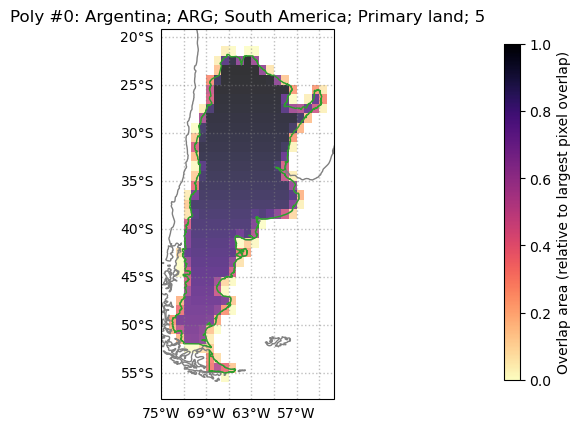

In [37]:
# xagg.diag.diag_fig(weightmap,0,t_nino_DJF_composite)

# test=xagg.fix_ds(t_nino_DJF_composite)
# weightmap.diag_fig(0,test)

# grid_polygon_info = xagg.subset_find(t_nino_DJF_composite,weightmap.source_grid)
# weightmap.diag_fig(1,grid_polygon_info)
# grid_polygon_info

weightmap.diag_fig(0,t_nino_DJF_composite.to_dataset())

In [ ]:
# to get the relative area of the country where nino anomalies meet the 90% confidence level
area_impacted=df.loc[df['pval']<=0.1].rel_area.sum()
area_impacted

To get the result for all countries we can write a function and loop. 

In [ ]:
def percent_area_impacted(coords,rel_area,xr_pval):
    df=pd.DataFrame(coords,columns=['lat','lon'])
    df['rel_area']=rel_area
    
    xr_pval.name='pval'
    pval_df=xr_pval.to_dataframe().reset_index(level=[0,1])
    df=df.merge(pval_df, how='left',on=['lat','lon'])

    area_impacted=df.loc[df['pval']<=0.1].rel_area.sum()*100.
    return area_impacted

In [ ]:
results={}
for index,row in weightmap.agg.iterrows():
    answer=percent_area_impacted(row.coords,row.rel_area[0],t_nino_pval)
    results[row.COUNTRY]=answer
results

In [ ]:
# access the dictionary with .source_grid
weightmap.source_grid

In [ ]:
weightmap.geometry

In [ ]:
pr_test=pr_anom.isel(time=0).to_dataset()
pr_test

In [ ]:
# testdf=pr_test.stack(cell=('lat','lon')).to_dataframe()#.to_pandas()#.drop_vars(['lat','lon'])
testdf=pr_test.to_dataframe().reset_index(level=[0,1])#.to_pandas()#.drop_vars(['lat','lon'])

# testdf=testdf.reindex()
testdf

In [ ]:
weightmap = xa.pixel_overlaps(pr_test,countries,subset_bbox=False)
weightmap

In [ ]:
rel_area=weightmap.agg['rel_area']
rel_area

In [ ]:
coords=weightmap.agg['coords']
coords

In [ ]:
# the relative area of each pixel intersecting the first polygon/mulipolygon
# would be indexed like this, which returns a pandas series of 351 values
rel_area[0][0]

In [ ]:
# the coordinates that correspond to the rel_area valuse/pixels
# would be indexed like this, which returns a list of 351 (lat,lon) tuples
coords[0]

In [ ]:
# for each polygon, we can create a df of pixel rel_area, center coordinates, and data value like this
df=pd.DataFrame(coords[0],columns=['lat','lon'])
df['rel_area']=rel_area[0][0]
df=df.merge(testdf, how='left',on=['lat','lon'])
df

In [ ]:
# to find the area where the data variable meets some criteria 
# for example, the magnitude of the pr anomaly gt 0.5

df_sub=df[abs(df['precip'])>=0.5]
relarea_criteria=df_sub['rel_area'].sum()
relarea_criteria

# now multiply by the area of the polygon

In [ ]:
# peru=countries.loc[9]
peru=countries[countries.COUNTRY=='Peru']
# peru
weightmap2 = xa.pixel_overlaps(pr_anom_ds,peru,subset_bbox=False)
weightmap2.agg['rel_area']

In [ ]:
weightmap2.agg

In [ ]:
weightmap2.agg.rel_area[0][0]

In [ ]:
sum(weightmap2.agg.rel_area[0][0])

In [ ]:
# np.array(weightmap2.agg.coords[0]).shape#.rel_area[0][0]

weightmap2.agg.coords[0]#[1][1])

In [ ]:
# # Querying polygon by column of the polygon `gdf`
# weightmap.diag_fig({'name':'Alaska'},ds)

# Plotting the first polygon in the polygon `gdf`
weightmap.diag_fig(0,pr_anom_ds)

In [ ]:
import rioxarray as rio
pr_anom_ds=pr_anom.to_dataset()
# pr_anom_ds=pr_anom_ds.rename({'lat':'y','lon':'x'})
# pr_anom_ds=pr_anom_ds.rio.write_crs('epsg:4326')
# pr_test=pr_anom_ds.rio.reproject('epsg:3857')
pr_test=pr_anom_ds
pr_test

In [ ]:
# pr_test=pr_test.rename({'y':'lat','x':'lon'})
pr_test=xa.auxfuncs.get_bnds(pr_test)
pr_test

In [ ]:
grid_poly=xa.core.create_raster_polygons(pr_test)
# grid_poly,grid_dict=xa.core.create_raster_polygons(pr_test) # doesn't work this way

gdf_pixels=grid_poly['gdf_pixels']
gdf_pixels

In [ ]:
gdf_pixels.crs

In [ ]:
weights = np.cos(np.deg2rad(pr_anom.lat))
weights.name = "weights"
# weights

In [ ]:
pr_weighted = pr_anom.weighted(weights)
pr_weighted

In [ ]:
# cdo gridarea yourdata.nc gridarea.nc 
ds=xr.open_dataset(pr_f)
ds